<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_03_FineTuning_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class

!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [2]:
# first mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

# Install Git Large File Storage (LFS) for handling large files in Git repositories
# !git lfs install

#Clone the Geneformer repository (commented out to avoid repeated cloning)
# !git clone https://huggingface.co/ctheodoris/Geneformer

# Navigate to the Geneformer directory
%cd Geneformer

# Install Geneformer package locally
# I found that installing Genformer first helped with a lot of the version conflict issues
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

Mounted at /content/drive
/content/drive/MyDrive/HODD/Geneformer
Processing /content/drive/MyDrive/HODD/Geneformer
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.8 MB/s eta

In [3]:
import datetime

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "park_classifier"

data_directory = '/content/drive/MyDrive/HODD/datasets/'

output_dir = f"/content/drive/MyDrive/HODD/models/{datestamp}"
!mkdir $output_dir

park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_tokenized.dataset/'

geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'


##Fine-tune the model for cell state classification

In [4]:
from geneformer import Classifier

# training_args = {
#     "num_train_epochs": 0.9,
#     "learning_rate": 0.0001,
#     "lr_scheduler_type": "polynomial",
#     "warmup_steps": 1812,
#     "weight_decay":0.258828,
#     "per_device_train_batch_size": 12,
#     "seed": 73,
#     "bf16":True
# }


training_args = {
    "num_train_epochs": 3,                      # 🔼 Increase epochs (0.9 is too low)
    "learning_rate": 5e-5,                      # 🔽 Reduce LR slightly (better for fine-tuning)
    "lr_scheduler_type": "linear",              # 🔄 More common for fine-tuning
    "warmup_steps": 500,                        # 🔽 Less warmup to start learning sooner (adjust if your dataset is large)
    "weight_decay": 0.01,                       # 🔽 Lower this to reduce over-regularization
    "per_device_train_batch_size": 8,          # 🔼 If you can fit it in memory
    "seed": 73,
    "bf16": True,                               # ✅ keep bf16
    "evaluation_strategy": "epoch",             # 🧪 Evaluate after every epoch (recommended)
    "save_strategy": "epoch",                   # 💾 Save at each epoch to allow rollback
    "load_best_model_at_end": True,             # 🔁 Helps auto-select the best checkpoint
    "metric_for_best_model": "eval_loss",       # 📉 Track best checkpoint by validation loss
    "greater_is_better": False                  # 👇 eval_loss should decrease
}

# uses the current default model

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=32,
                nproc=16)

In [5]:
#datsets imports for handling tokenized dataset
from datasets import load_dataset, load_from_disk, ClassLabel

#load the training data
park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_tokenized.dataset/'
park_data = load_from_disk(park_data_path)

# Add an 'id' column that stores the original index
park_data = park_data.add_column("id", list(range(len(park_data))))

park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_with_id_tokenized.dataset/'

# save it back to disk
park_data.save_to_disk(park_data_with_id_path)

# Get the unique values from the "disease_state_numeric" column
classes = list(set(park_data["disease_state"]))

# make the disease state column a classlabel
park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="disease_state") #establish test and train with stratification
split_data = split_data.rename_column("disease_state", "label")  # for compatibility with classifier_utils call in classifer.train_classifier

# split test and train
train_data = split_data['train']
test_data = split_data['test']

# split train into training and evaluation set
train_data, eval_data = split_data['train'].train_test_split(test_size=0.2, seed=42, stratify_by_column="label").values()

print(len(train_data))
print(len(eval_data))
print(len(test_data))

# Create dictionary of split indices
train_ids = train_data["id"]
eval_ids = eval_data["id"]
test_ids = test_data["id"]

train_test_id_split_dict = {"attr_key": "id",
                            "train": train_ids+eval_ids,
                            "test": test_ids}

cc.prepare_data(input_data_file=park_data_with_id_path,
                output_directory=data_directory,
                output_prefix=output_prefix,
                split_id_dict=train_test_id_split_dict)

4137
1035
1294


In [7]:
import torch
torch.cuda.empty_cache()

train_valid_id_split_dict = {"attr_key": "id",
                            "train": train_ids,
                            "eval": eval_ids}

os.environ["WANDB_DISABLED"] = "true"

# fine tune the model
all_metrics = cc.validate(model_directory=geneformer_directory,
                          prepared_input_data_file=f"{data_directory}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{data_directory}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.254700,0.127907,0.967150,0.961141
2,0.127000,0.080786,0.978744,0.975687
3,0.026700,0.079150,0.983575,0.981108


/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/drive/MyDrive/HODD/Geneformer/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


  0%|          | 0/33 [00:00<?, ?it/s]

In [8]:
all_metrics

{'conf_matrix':                    Parkinson_disease  normal
 Parkinson_disease              322.0     6.0
 normal                          11.0   696.0,
 'macro_f1': [np.float64(0.9811080486477142)],
 'acc': [0.9835748792270531],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.97312588, 0.99009901, 0.99292786, 0.99575672,
         0.99575672, 0.99575672, 0.99575672, 0.99575672, 0.99575672,
         0.99575672, 0.99575672, 0.99717115, 0.99858557, 0.99858557,
         0.99858557, 0.99858557, 0.99858557, 0.99858557, 0.99858557,
         0.99858557, 0.99858557, 0.99858557, 0.99858557, 0.99858557,
         0.99975712, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1. 

##Evaluate the model

In [27]:
#saved previous model locations due to gpu memory issues

current_model = '/content/drive/MyDrive/HODD/models/250410124655/250410_geneformer_cellClassifier_park_classifier/ksplit1/'
current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
test_data_file = '/content/drive/MyDrive/HODD/datasets/park_classifier_labeled_test.dataset'
output_dir = '/content/drive/MyDrive/HODD/models/250410124655/'
output_prefix = "park_classifier"

In [24]:
from geneformer import Classifier

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                forward_batch_size=36,
                nproc=16)

In [25]:
all_metrics_test = cc.evaluate_saved_model(
        # model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        model_directory=current_model,
        # id_class_dict_file=f"{data_directory}{output_prefix}_id_class_dict.pkl",
        id_class_dict_file=current_dict,
        # test_data_file=f"{data_directory}{output_prefix}_labeled_test.dataset",
        test_data_file = test_data_file,
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/36 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

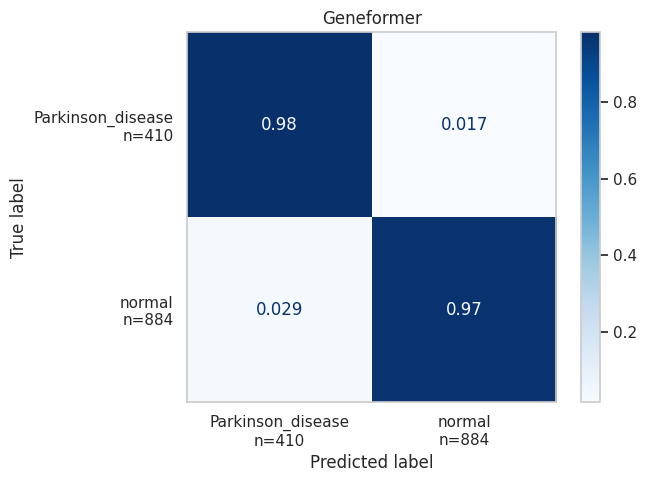

In [14]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        # custom_class_order=["nf","hcm","dcm"],
)

<Figure size 1500x1500 with 0 Axes>

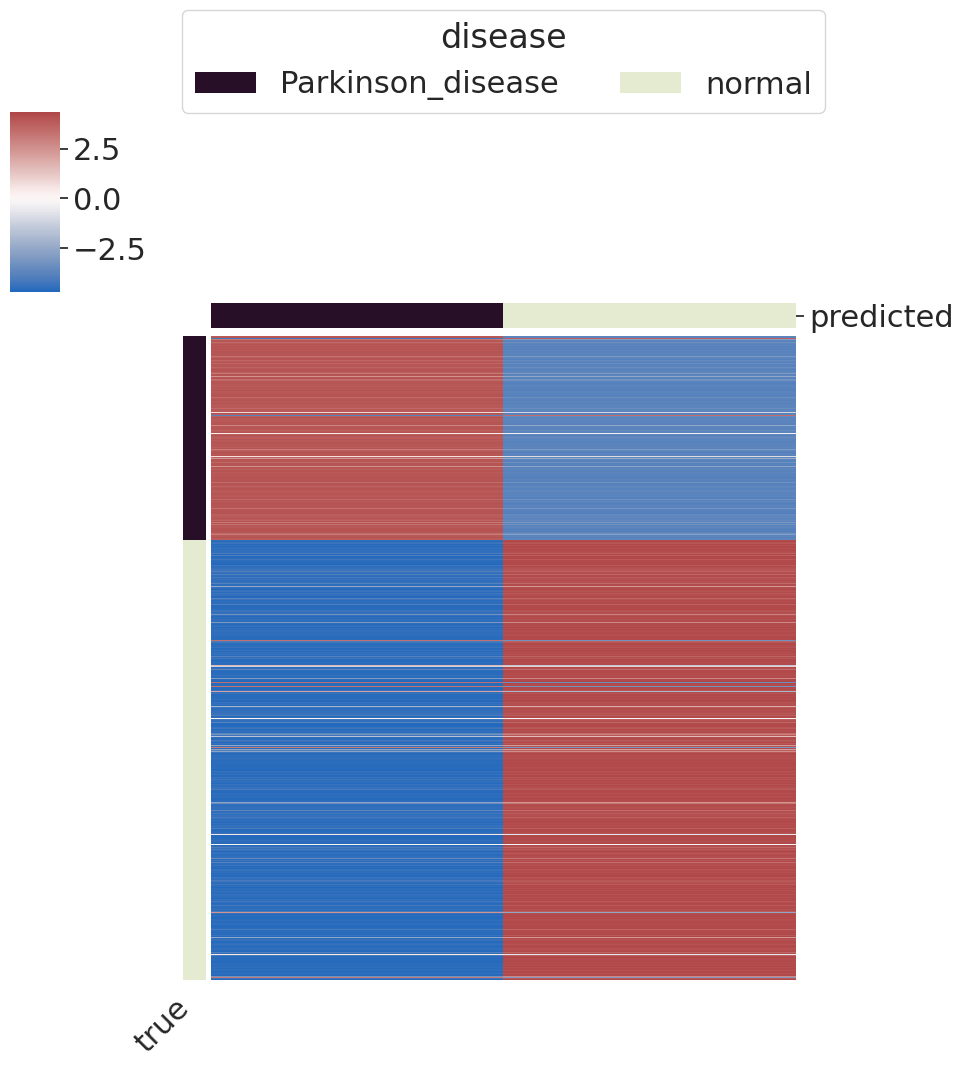

In [28]:
cc.plot_predictions(
    predictions_file=f"{output_dir}{output_prefix}_pred_dict.pkl",
    # id_class_dict_file=f"{output_dir}{output_prefix}_id_class_dict.pkl",
    id_class_dict_file = current_dict,
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
    # custom_class_order=["nf","hcm","dcm"],
)